# Advanced Lane Finding

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 0. Dependencys

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

out_dir='output_images/'
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

## 1. Camera Calibration

In [2]:
def gen_obj_points (size):
    objp = np.zeros ((size[0] * size[1], 3), np.float32)
    objp [:, :2] = np.mgrid [0:size[0], 0:size[1]].T.reshape (-1, 2)
    return objp

obj_points = []
img_points = []

calibration_images = []
for file in glob.glob("camera_cal/calibration*.jpg"):
    img = cv2.imread (file)
    gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
    
    # there are not all chessboard corners detected on all images
    # sometime it detects smaller patterns
    # that's why I use different patterns to detect as much corners as possible
    
    pattern_size = (9, 6)
    found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (9, 5)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (8, 6)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (7, 6)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)

    if (found):
        # saving corresponding object points
        obj_points.append (gen_obj_points (pattern_size))
        img_points.append (corners)
        cv2.drawChessboardCorners(img, pattern_size, corners, found) 
        image_name=os.path.split(file)[1]
        write_name = out_dir+'corners_found_ny'+ str(pattern_size) +'_'+image_name
        cv2.imwrite(write_name, img)
        print(file)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)


camera_cal/calibration16.jpg
camera_cal/calibration12.jpg
camera_cal/calibration10.jpg
camera_cal/calibration15.jpg
camera_cal/calibration1.jpg
camera_cal/calibration9.jpg
camera_cal/calibration14.jpg
camera_cal/calibration7.jpg
camera_cal/calibration17.jpg
camera_cal/calibration3.jpg
camera_cal/calibration18.jpg
camera_cal/calibration13.jpg
camera_cal/calibration8.jpg
camera_cal/calibration20.jpg
camera_cal/calibration5.jpg
camera_cal/calibration4.jpg
camera_cal/calibration2.jpg
camera_cal/calibration11.jpg
camera_cal/calibration19.jpg
camera_cal/calibration6.jpg


In [3]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

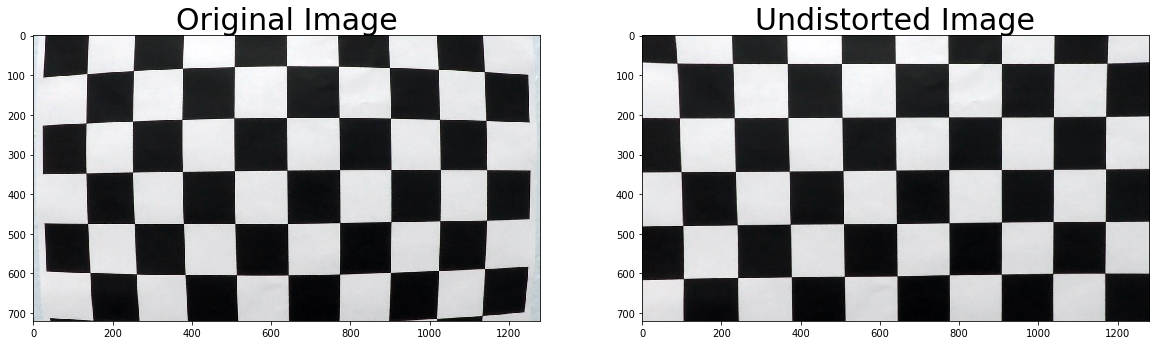

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')

img_undistort = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

## 2. Undistorting

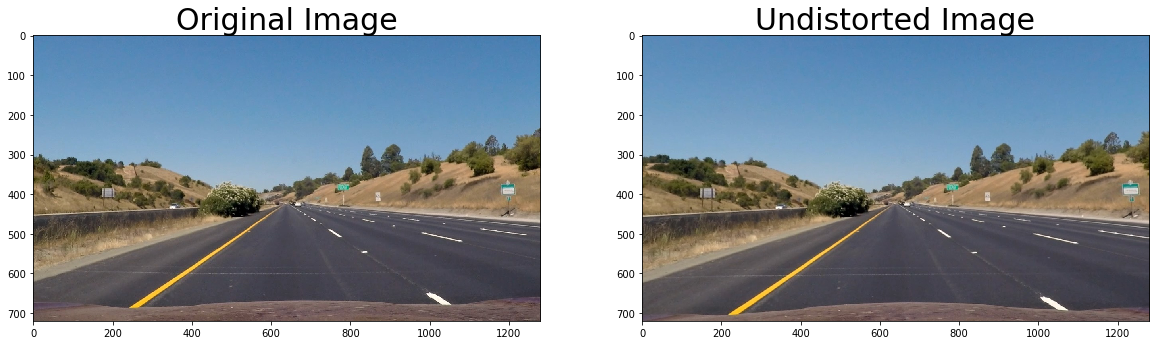

In [6]:
# Test undistortion on an image
img = cv2.cvtColor(cv2.imread ('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

# Do camera calibration given object points and image points
img_undistort = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Create a thresholded binary image

In [7]:
def abs_sobel_thresholding(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

def get_S_L(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    return S, L

def light_mask(L, S):
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 130)] = 1
    return light_mask
    
# Retuns binary image based on thresholding functions
def get_binary_image(image):
    S, L = get_S_L(image)
    
    lm = light_mask(L, S)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresholding(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresholding(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (lm == 1)] = 1
    
    return combined

(0.0, 1.0, 0.0, 1.0)

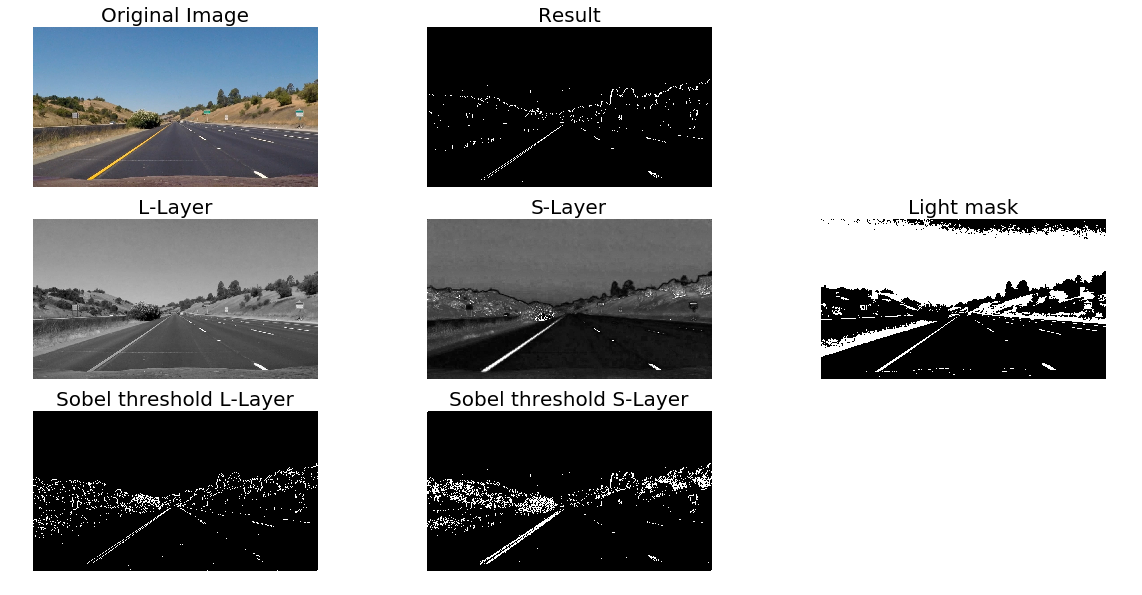

In [8]:
# Test undistortion on an image
img = cv2.cvtColor(cv2.imread ('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

S, L = get_S_L(img)
lm = light_mask(L, S)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx_l = abs_sobel_thresholding(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
gradx_s = abs_sobel_thresholding(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))

# Do camera calibration given object points and image points
combined = get_binary_image(img)

f, ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33))= plt.subplots(3, 3, figsize=(20,10))

ax11.set_title('Original Image', fontsize=20)
ax11.axis('off')
ax11.imshow(img)

ax12.set_title('Result', fontsize=20)
ax12.axis('off')
ax12.imshow(combined, cmap='gray')

ax13.axis('off')

ax21.set_title('L-Layer', fontsize=20)
ax21.axis('off')
ax21.imshow(L, cmap='gray')

ax22.set_title('S-Layer', fontsize=20)
ax22.axis('off')
ax22.imshow(S, cmap='gray')

ax23.set_title('Light mask', fontsize=20)
ax23.axis('off', cmap='gray')
ax23.imshow(lm, cmap='gray')
          
ax31.set_title('Sobel threshold L-Layer', fontsize=20)
ax31.axis('off')
ax31.imshow(gradx_l, cmap='gray')

ax32.set_title('Sobel threshold S-Layer', fontsize=20)
ax32.axis('off')
ax32.imshow(gradx_s, cmap='gray')

ax33.axis('off')          

## 4. Perspective transform

In [9]:
# determine perspective transform matrix
img = cv2.cvtColor(cv2.imread ('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
img_undistort =  undistort(img, mtx, dist)

marked = cv2.circle (img_undistort, (285, 671), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (420, 577), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (880, 577), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (1000, 651), 10, (0, 0, 255), -1)

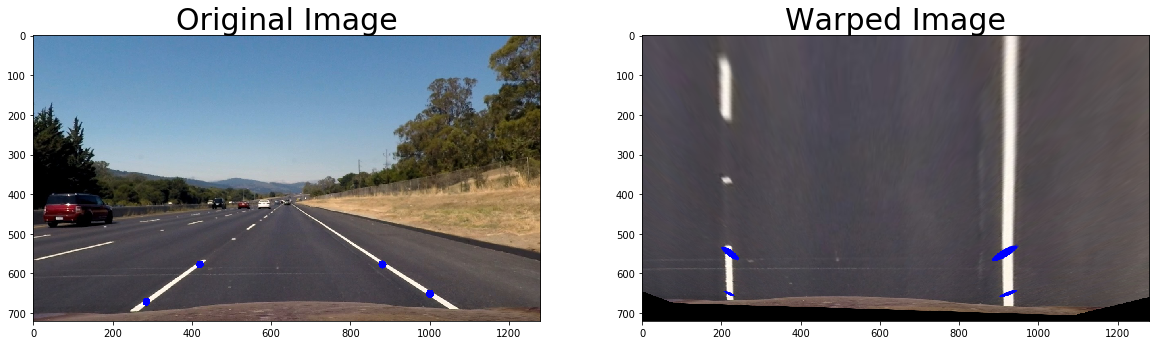

In [10]:
#handcrafted road points for perspective projection matrix calculation
src = np.float32 ([
        [285, 671],
        [418, 577],
        [885, 577],
        [1000, 651]
    ])

dst = np.float32 ([
        [220, 651],
        [220, 550],
        [921, 550],
        [921, 651]
    ])
M = cv2.getPerspectiveTransform (src, dst)

M_inv = cv2.getPerspectiveTransform (dst, src)

def warp (image):
    img_size = (image.shape [1], image.shape [0])
    warped =  cv2.warpPerspective ( image, M, img_size, flags=cv2.INTER_LINEAR )
    return warped


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(marked)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warp(marked))
ax2.set_title('Warped Image', fontsize=30)

## 5. Image Pipeline

In [11]:
def pipline(img, mtx = None, dist = None, do_undistort=True, do_warp=True, do_binary=True):
    if(do_undistort):
        img = undistort(img, mtx, dist)
    if(do_warp):
        img = warp(img)
    if(do_binary):
        img = get_binary_image(img)
    return img


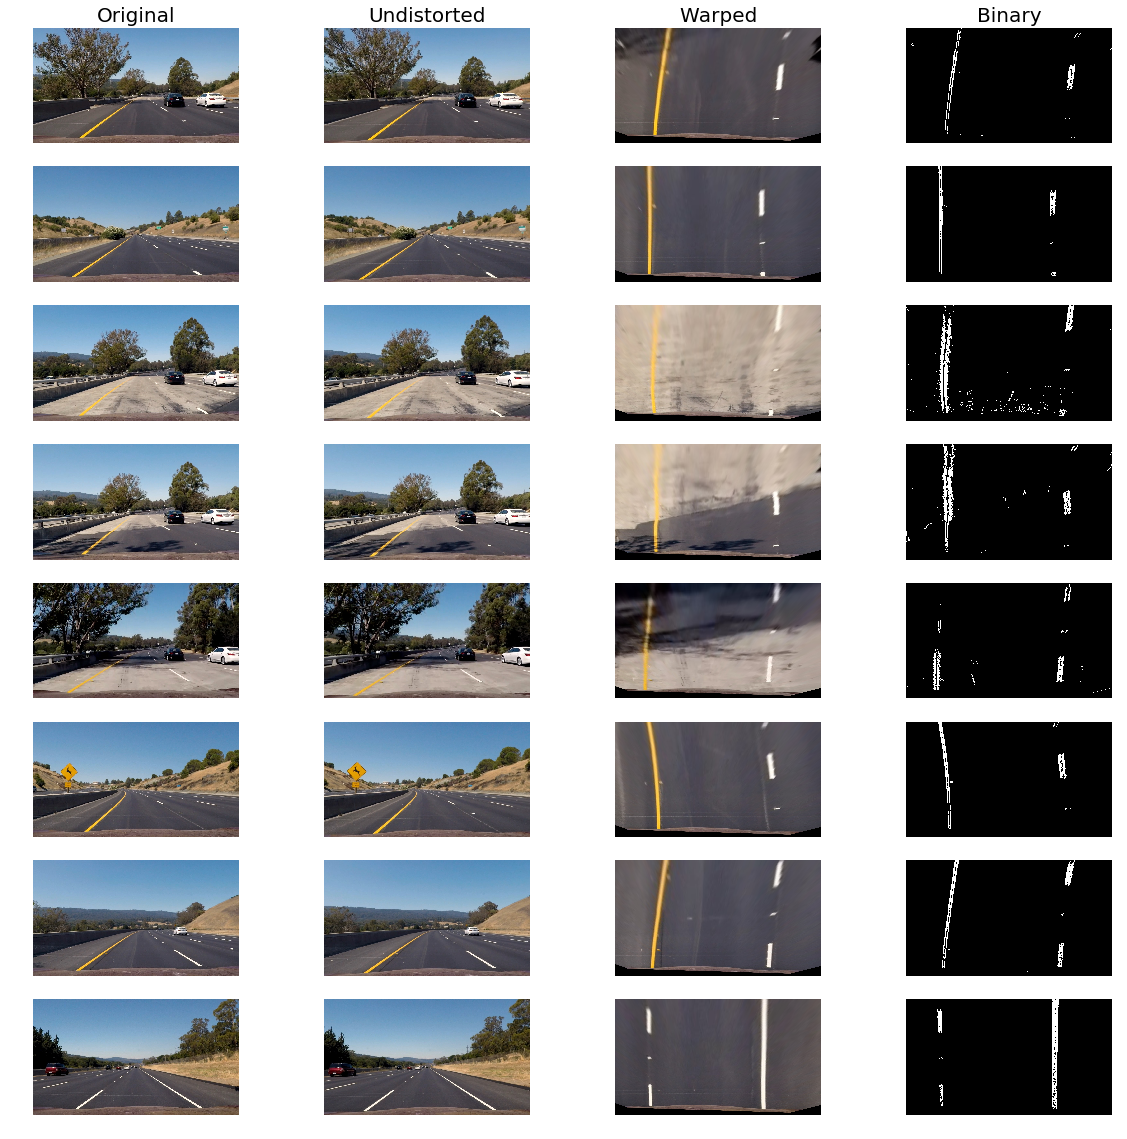

In [12]:
images = glob.glob('./test_images/*.jpg')
i = 0
COLUMNS_HEADER = ['Original', 'Undistorted', 'Warped', 'Binary']
fig, axs = plt.subplots(len(images), len(COLUMNS_HEADER), figsize=(20,20))
axs = axs.ravel()

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undistort = pipline(img, mtx, dist, do_warp=False, do_binary=False)
    img_warped = pipline(img, mtx, dist, do_binary=False)
    img_binary = pipline(img, mtx, dist)
   
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(img)
    axs[i].axis('off')
    
    i += 1
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(img_undistort)
    axs[i].axis('off')
    
    i += 1
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(img_warped)
    axs[i].axis('off')
    
    i += 1
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(img_binary, cmap='gray')
    axs[i].axis('off')
    i += 1
    
    

## 6. Sliding Window Polyfit

In [13]:
def slidewindow(dst):
    histogram = np.sum(dst[int(dst.shape[0]/2):,:], axis=0)
    ploty = np.linspace(0, dst.shape[0]-1, dst.shape[0] )
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((dst, dst, dst))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 17#11
    # Set height of windows
    window_height = np.int(dst.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100#70 #80
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = dst.shape[0] - (window+1)*window_height
        win_y_high = dst.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    kk=out_img
    
    return leftx, lefty, rightx, righty,left_fitx,right_fitx,left_fit,right_fit, kk, histogram

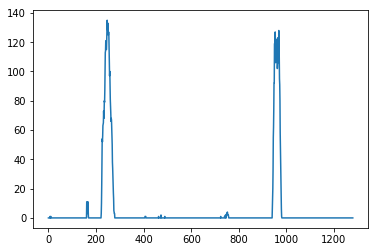

In [14]:
image = cv2.imread('./test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_binary = pipline(image, mtx, dist)
image_analysed=slidewindow(img_binary)
histogram = np.sum(img_binary[int(img_binary.shape[0]/2):,:], axis=0)
plt.plot(image_analysed[9])
plt.show()

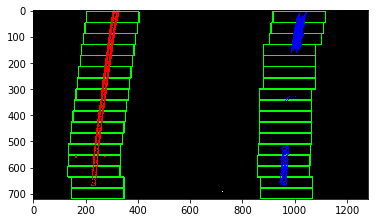

In [15]:
plt.imshow(image_analysed[8])

In [16]:
def drawLines(img_binary, image_analysed):
    left_fitx=image_analysed[4]
    right_fitx=image_analysed[5]
    left_fit=image_analysed[6]
    right_fit=image_analysed[7]
    ploty = np.linspace(0, img_binary.shape[0]-1, img_binary.shape[0] )

    plt.imshow(img_binary,cmap='gray')
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

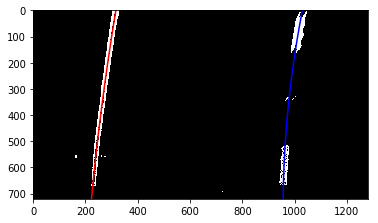

In [17]:
drawLines(img_binary, image_analysed)

In [18]:
def polyfit_on_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 80
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & 
                      (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & 
                       (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    # Fit a second order polynomial
    left_fit, right_fit = (None, None)
    if len(left_x) != 0:
        left_fit = np.polyfit(left_y, left_x, 2)
    if len(right_x) != 0:
        right_fit = np.polyfit(right_y, right_x, 2)
    return left_fit, right_fit, left_lane_indices, right_lane_indices

left_fit=image_analysed[6]
right_fit=image_analysed[7]
left_fit, right_fit, left_lane_indices, right_lane_indices = polyfit_on_fit(img_binary, left_fit, right_fit)

In [19]:
def calculate_curvature_distance(bin_img, left_fit, right_fit, left_lane_indices, right_lane_indices):
    
    # 10ft = 3.05meters
    x_meters_per_pixel = 3.7/378
    
    # 12ft = 3.8meters
    y_meters_per_pixel = 3.048/100 
    left_curve_radius, right_curve_radius, center_distance = (0, 0, 0)
    
    # y-value radius of curvature (bo)
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    
    # Bottom of image (max height)
    y_bottom = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels
    nonzero = bin_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    if len(left_x) != 0 and len(right_x) != 0:
        # Fit polynomials to x and y
        left_fit_cr = np.polyfit(left_y*y_meters_per_pixel, left_x*x_meters_per_pixel, 2)
        right_fit_cr = np.polyfit(right_y*y_meters_per_pixel, right_x*x_meters_per_pixel, 2)
        
        # Calculate the radius of curvature in meters
        left_curve_radius = ((1 + (2*left_fit_cr[0]*y_bottom*y_meters_per_pixel + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_radius = ((1 + (2*right_fit_cr[0]*y_bottom*y_meters_per_pixel + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Distance from center is image x midpoint
    if right_fit is not None and left_fit is not None:
        car_position = bin_img.shape[1]/2
        left_fit_x = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (right_fit_x + left_fit_x) /2
        center_distance = (car_position - lane_center_position) * x_meters_per_pixel
        
    return left_curve_radius, right_curve_radius, center_distance

radius_left, radius_right, distance_center = calculate_curvature_distance(img_binary, left_fit, right_fit, left_lane_indices, right_lane_indices)

print('Radius of curvature:', radius_left, 'm,', radius_right, 'm')
print('Distance from lane center:', distance_center, 'm')


Radius of curvature: 951.81494458 m, 370.359169327 m
Distance from lane center: 0.491698047927 m


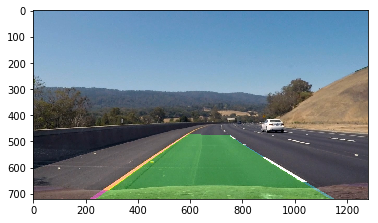

In [20]:
def draw_lane(img, binary_img, left_fit, right_fit, Minv):
    if left_fit is None or right_fit is None:
        return img
    
    img_copy = np.copy(img)
    
    # Create an empty image
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Preprocess x and y points for fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix
    img_warped = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_copy, 1, img_warped, 0.3, 0)
    
    return result

sample_image_out = draw_lane(image, img_binary, left_fit, right_fit, M_inv)
plt.imshow(sample_image_out)
